In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

%matplotlib inline

In [96]:
# load dataset
ds = datasets.fetch_california_housing()
X = ds.data.astype(np.float32)
y = ds.target.astype(np.float32)

# remove very cheap or very expensive homes (saturates =< 0.15 or >= 5)
ind = (y > 0.15) & (y < 5)
X = X[ind,:]
y = y[ind]

# transform target - more Gaussian
y = np.log(y)

# scale input attributes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split data into train and test - !!! added valid dataset for pytorch
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.33, random_state=0)

In [97]:
# info about the dataset
print(ds.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [98]:
# tensorize data
ts_X_train, ts_y_train, ts_X_valid, ts_y_valid, ts_X_test, ts_y_test = map(
    torch.tensor, (X_train, y_train.reshape(-1,1), X_valid, y_valid.reshape(-1,1), X_test, y_test.reshape(-1,1))
)

In [99]:
model = torch.load('nonlin_reg.nn')

In [100]:
model

Sequential(
  (0): Linear(in_features=8, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=100, out_features=50, bias=True)
  (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=50, out_features=2, bias=True)
  (7): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ELU(alpha=1.0)
  (9): Linear(in_features=2, out_features=1, bias=True)
)

In [101]:
model[:-1]

Sequential(
  (0): Linear(in_features=8, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=100, out_features=50, bias=True)
  (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=50, out_features=2, bias=True)
  (7): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ELU(alpha=1.0)
)

In [102]:
# remove the last layer
feat_model = model[:-1]

feat_model.eval()
with torch.no_grad():
    feat_pred = feat_model(ts_X_test).numpy()

In [103]:
feat_pred

array([[-0.8837479 ,  0.8785401 ],
       [-0.5387683 , -0.36997223],
       [-0.31477886,  0.19918817],
       ...,
       [ 0.3027098 , -0.744913  ],
       [-0.61174923, -0.07336146],
       [-0.7058748 ,  0.31106007]], dtype=float32)

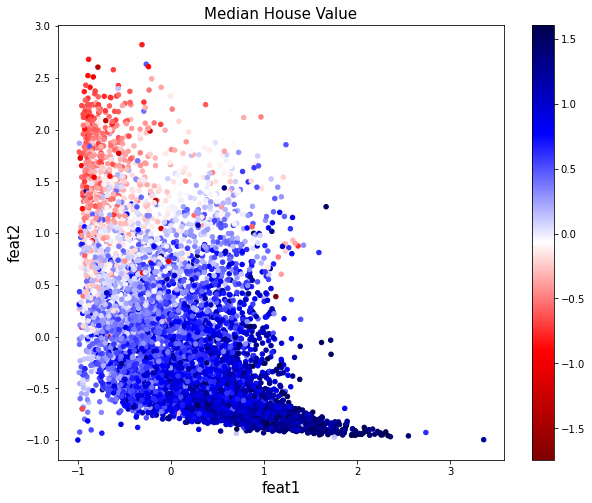

In [104]:
# 2d features vs house value
plt.figure(figsize=(10,8))
plt.scatter(feat_pred[:,0], feat_pred[:,1], s=20, c=y_test, cmap='seismic_r')
plt.title('Median House Value', fontsize=15)
plt.xlabel('feat1', fontsize=15)
plt.ylabel('feat2', fontsize=15)
plt.colorbar()

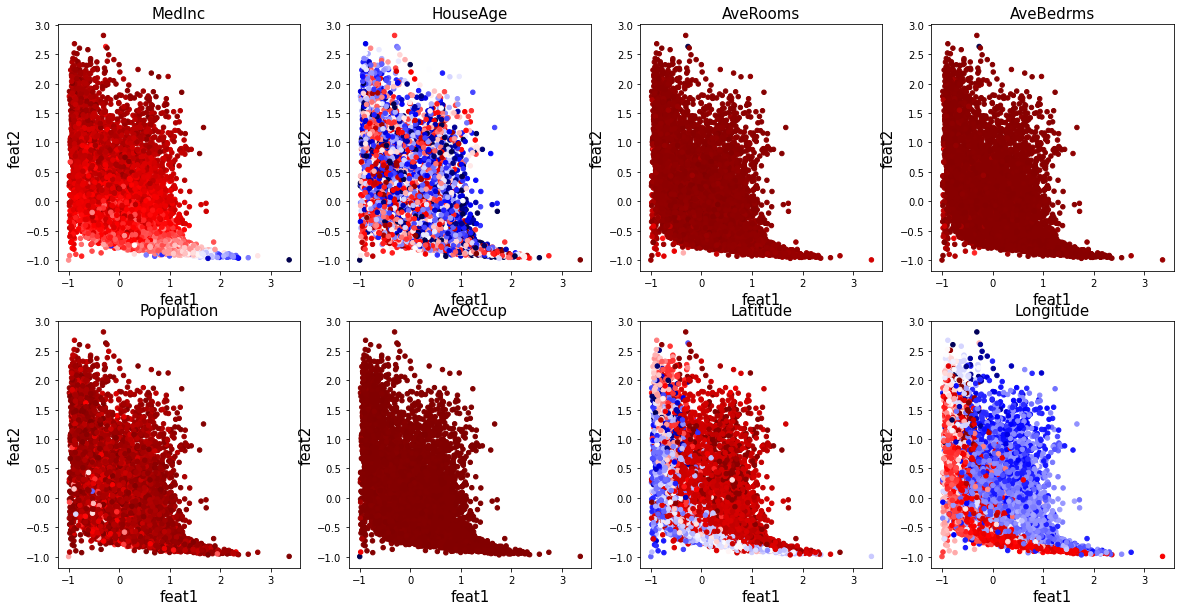

In [105]:
# connection of 2d features to original inputs
i = 0
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(8):
    ax = axs[i//4,i%4]
    ax.scatter(feat_pred[:,0], feat_pred[:,1], s=20, c=X_test[:,i], cmap='seismic_r')
    ax.set_title(ds.feature_names[i], fontsize=15)
    ax.set_xlabel('feat1', fontsize=15)
    ax.set_ylabel('feat2', fontsize=15)
# plt.colorbar()
plt.show()

In [106]:
model[-1]

Linear(in_features=2, out_features=1, bias=True)

In [107]:
# check the weights for the last layer
for name, param in model[-1].named_parameters():
    if param.requires_grad:
        print(name, ':', param)

weight : Parameter containing:
tensor([[ 0.2760, -0.4293]], requires_grad=True)
bias : Parameter containing:
tensor([0.5157], requires_grad=True)


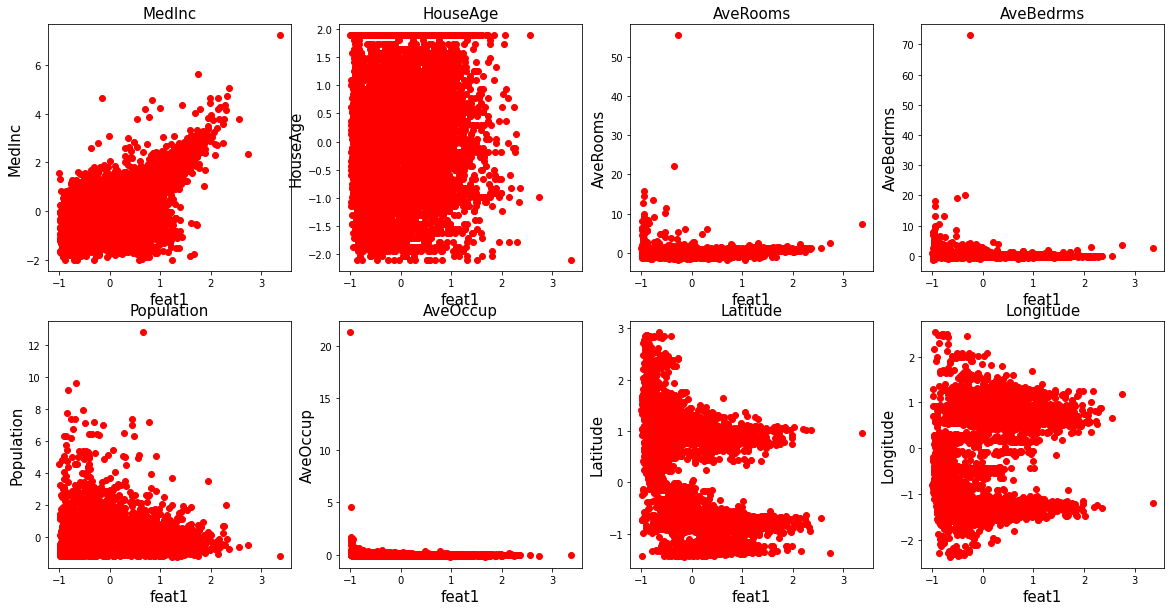

In [108]:
# correlation feat1 with inputs
i = 0
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(8):
    ax = axs[i//4,i%4]
    ax.scatter(feat_pred[:,0], X_test[:,i], c='red')
    ax.set_title(ds.feature_names[i], fontsize=15)
    ax.set_xlabel('feat1', fontsize=15)
    ax.set_ylabel(ds.feature_names[i], fontsize=15)
# plt.colorbar()
plt.show()

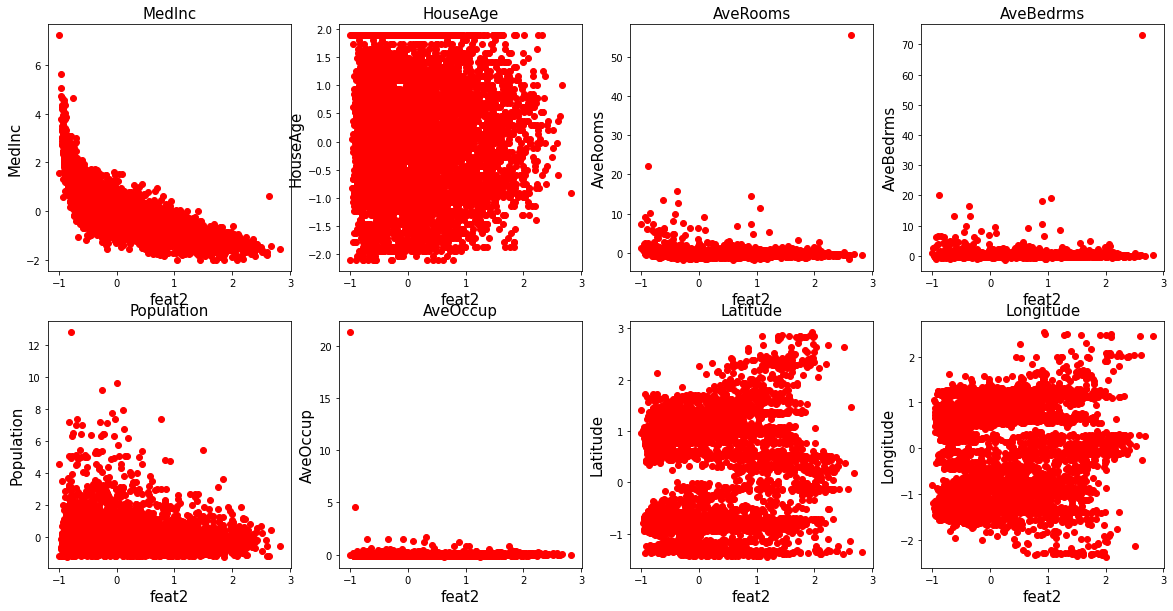

In [109]:
# correlation feat2 with inputs
i = 0
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(8):
    ax = axs[i//4,i%4]
    ax.scatter(feat_pred[:,1], X_test[:,i], c='red')
    ax.set_title(ds.feature_names[i], fontsize=15)
    ax.set_xlabel('feat2', fontsize=15)
    ax.set_ylabel(ds.feature_names[i], fontsize=15)
# plt.colorbar()
plt.show()